In [1]:
import torch
from torch import nn
from torch.autograd import Variable
import torch.optim as optim
from collections import OrderedDict
from scipy.stats import ortho_group
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from time import time
%matplotlib inline

### Setup

In [2]:
# use nvidia gpu if available
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
# only float32 tested
dtype = torch.float32
    
print("Device:", device)
print("Data type:", dtype)

Device: cuda
Data type: torch.float32


### Define Encoder/Decoder Logic

In [3]:
class L2Norm(nn.Module):
    """L2Norm model class -- a layer class for normalizing a matrix of vectors
    
    Args:
        dim (int) - which dimension to normalize along. 0 for column vectors, 1 for row vectors
    """
    def __init__(self, dim=-1):
        super(L2Norm, self).__init__()
        
        self.dim=dim
        
    def forward(self,input):
        return nn.functional.normalize(input, p=2, dim=self.dim)

In [28]:
class Hamiltonian(nn.Module):
    """Hamiltonian -- a class used to help learn physically relevant sub-manifold
    
    Args:
        H - the hamiltonian matrix in the original basis
        N (int) - the size of the original basis
        N_proj (int) - the size of the projected basis
    """
    
    def __init__(self, H, N, N_proj, kernel_size=(1,7)):

        super(Hamiltonian, self).__init__()
        
        # initialize the class variables
        self.H = H
        self.N = N
        self.N_inter = N // 2**6
        self.N_proj = N_proj
        self.eye = torch.eye(N_proj, device=device, dtype=dtype)[None, None]
        
        padding = tuple([(ks-1)//2 for ks in kernel_size])
        
        # initialize the encoder and decoder architectures
        self.decoder = nn.Sequential(OrderedDict([
            ('matmul', nn.Linear(self.N_proj, self.N_inter, bias=False)),
            ('conv2dT_1', nn.ConvTranspose2d(1,1, kernel_size, padding=padding, stride=(1,2), output_padding=(0,1), bias=False)),
            ('conv2dT_2', nn.ConvTranspose2d(1,1, kernel_size, padding=padding, stride=(1,2), output_padding=(0,1), bias=False)),
            ('conv2dT_3', nn.ConvTranspose2d(1,1, kernel_size, padding=padding, stride=(1,2), output_padding=(0,1), bias=False)),
            ('conv2dT_4', nn.ConvTranspose2d(1,1, kernel_size, padding=padding, stride=(1,2), output_padding=(0,1), bias=False)),
            ('conv2dT_5', nn.ConvTranspose2d(1,1, kernel_size, padding=padding, stride=(1,2), output_padding=(0,1), bias=False)),
            ('conv2dT_6', nn.ConvTranspose2d(1,1, kernel_size, padding=padding, stride=(1,2), output_padding=(0,1), bias=True)),
            ('normalize', L2Norm())
        ]))

    # return the current cost matrix
    def forward(self):
        M = self.decoder(self.eye).squeeze()
        return M @ self.H @ M.t(), M @ M.t()

In [23]:
class Cost():
    """Cost class -- used to calculate goodness of projection map for optimization purposes
    
    Args:
        N_proj - number of basis states in the projected space
        alpha (float) - the weight of the orthogonality cost relative to the energy cost (units of energy)
    """
    
    def __init__(self, N_proj, alpha):
        super(Cost, self).__init__()
        
        self.N_proj = N_proj
        self.eye = torch.eye(N_proj, device=device, dtype=dtype)
        self.sorter = torch.tensor([[1/np.sqrt((i+1)*(j+1)) for i in range(self.N_proj)] for j in range(self.N_proj)], device=device, dtype=dtype)
        
    def __call__(self, Hproj, Iproj):
        cost_matrix = (Hproj*self.sorter)**2 + alpha * (Iproj - self.eye)**2
        return cost_matrix.sum()/self.N_proj**2

### Synthesize a reasonable test Hamiltonian

In [7]:
generate_H_banded(2,4)

tensor([[1.0332, 1.4210, 0.0000, 0.0000],
        [1.4210, 4.5370, 1.8411, 0.0000],
        [0.0000, 1.8411, 4.6083, 2.3399],
        [0.0000, 0.0000, 2.3399, 6.6977]], device='cuda:0')

In [8]:
def generate_H(N, N_proj):
    eigs,_ = (torch.rand(N, device=device, dtype=dtype)*N).sort()
    Hgen_proj = torch.diag(eigs)
    Wgen = torch.tensor(ortho_group.rvs(N), device=device, dtype=dtype)
    
    Hgen = Wgen @ Hgen_proj @ Wgen.t()
    
    return Hgen, Wgen, eigs

In [14]:
# Hamiltonian Setup
N=2**14
print(N)
N_proj=30
coupling_dist=30
alpha=1

16384


In [15]:
# Hgen, Wgen, eigs = generate_H(N, N_proj)
# print ("eigs:", eigs[:N_proj])

In [16]:
coupling_dist=30
Hgen_diag = generate_H_banded(coupling_dist, N)

In [17]:
%time eigs_diag = torch.symeig(Hgen_diag, eigenvectors=False).eigenvalues[:N_proj]
eigs_diag

CPU times: user 11min 4s, sys: 29.4 s, total: 11min 34s
Wall time: 34.9 s


tensor([ 0.5801,  1.7741,  3.1881,  5.8022,  8.5677, 10.2439, 12.6479, 14.9341,
        17.7190, 19.2133, 21.2615, 22.8484, 24.5346, 25.7476, 27.9928, 29.3528,
        30.6014, 31.4637, 32.4710, 33.0386, 33.2531, 34.2094, 34.7642, 36.1422,
        37.1879, 37.8726, 39.3432, 40.3767, 41.4683, 42.7154], device='cuda:0')

In [46]:
# the hamiltonian model
model = Hamiltonian(Hgen_diag, N, N_proj, kernel_size=(1,31)).to(device=device)

In [47]:
print(model)

Hamiltonian(
  (decoder): Sequential(
    (matmul): Linear(in_features=30, out_features=256, bias=False)
    (conv2dT_1): ConvTranspose2d(1, 1, kernel_size=(1, 31), stride=(1, 2), padding=(0, 15), output_padding=(0, 1), bias=False)
    (conv2dT_2): ConvTranspose2d(1, 1, kernel_size=(1, 31), stride=(1, 2), padding=(0, 15), output_padding=(0, 1), bias=False)
    (conv2dT_3): ConvTranspose2d(1, 1, kernel_size=(1, 31), stride=(1, 2), padding=(0, 15), output_padding=(0, 1), bias=False)
    (conv2dT_4): ConvTranspose2d(1, 1, kernel_size=(1, 31), stride=(1, 2), padding=(0, 15), output_padding=(0, 1), bias=False)
    (conv2dT_5): ConvTranspose2d(1, 1, kernel_size=(1, 31), stride=(1, 2), padding=(0, 15), output_padding=(0, 1), bias=False)
    (conv2dT_6): ConvTranspose2d(1, 1, kernel_size=(1, 31), stride=(1, 2), padding=(0, 15), output_padding=(0, 1))
    (normalize): L2Norm()
  )
)


In [48]:
print(model.decoder.matmul(model.eye).shape)
print(model.decoder.conv2dT_1(model.decoder.matmul(model.eye)).shape)
print(model.decoder.conv2dT_2(model.decoder.conv2dT_1(model.decoder.matmul(model.eye))).shape)
print(model.decoder.conv2dT_3(model.decoder.conv2dT_2(model.decoder.conv2dT_1(model.decoder.matmul(model.eye)))).shape)

torch.Size([1, 1, 30, 256])
torch.Size([1, 1, 30, 512])
torch.Size([1, 1, 30, 1024])
torch.Size([1, 1, 30, 2048])


In [49]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = [np.prod(p.size()) for p in model_parameters]
print(params)
print(np.sum(params))

[7680, 31, 31, 31, 31, 31, 31, 1]
7867


In [50]:
(N*N_proj)/np.sum(params)

62.4787085292996

In [51]:
# loss function and optimizer
criterion = Cost(N_proj, alpha)
optimizer = optim.Rprop(model.parameters(), lr=0.01)

### Optimization

In [52]:
def early_stop(errs, rel_tol, patience=2):
    stop=True
    for i in range(patience):
        rel_change = np.abs(errs[-(i+1)] - errs[-(i+2)]) / errs[-(i+1)]
        stop = stop and rel_change < rel_tol
    return stop

def optimize(n_iter, n_save, show_progress=True, stop_early=True, rel_tol=0.01, patience=2):
    model.decoder.matmul.reset_parameters()
    running_loss= 0
    start_time = time()
    
    # store progress every n_save iters
    j=0
    its = []
    errs = []
    Hps = []
    Ips = []
    ts = []
    
    # iterate
    for i in range(n_iter):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        Hp, Ip = model()
        loss = criterion(Hp, Ip)
        loss.backward()
        optimizer.step()

        # print /save statistics
        running_loss += loss.item()
        if i % n_save == 0:
            # save progress
            its.append(i)
            errs.append(running_loss / n_save)
            Hps.append(Hp)
            Ips.append(Ip)
            ts.append(time() - start_time)
            
            # print progress 
            if show_progress:
                change = errs[j]-errs[j-1] if j>0 else 0
                print('[%d] loss: %.8f. diff: %.8f. time: %.4f' % (i + 1, errs[j], change, ts[-1]))
            
            if j>=patience and stop_early and early_stop(errs, rel_tol, patience):
                print("Early stopping criteria met.")
                break
            
            running_loss = 0.0
            j+=1
            

    print('Finished Training')
    return its, errs, Hps, Ips, ts

In [53]:
# Test
n_iter=6000
n_print=200
its, errs, hps, ips, ts = optimize(n_iter, n_print, stop_early=True, rel_tol=0.01, patience=3, show_progress=True)

[1] loss: 1478949.60000000. diff: 0.00000000. time: 0.0159
[201] loss: 4275531.14293458. diff: 2796581.54293458. time: 2.3770
[401] loss: 0.25170356. diff: -4275530.89123102. time: 4.7090
[601] loss: 0.21341873. diff: -0.03828483. time: 7.0447
[801] loss: 0.19800701. diff: -0.01541172. time: 9.1894
[1001] loss: 0.18698034. diff: -0.01102667. time: 11.3343
[1201] loss: 0.17712977. diff: -0.00985058. time: 13.4818
[1401] loss: 0.16837663. diff: -0.00875313. time: 15.6192
[1601] loss: 0.16184505. diff: -0.00653158. time: 17.7607
[1801] loss: 0.15687997. diff: -0.00496508. time: 19.8977
[2001] loss: 0.15330636. diff: -0.00357362. time: 22.0234
[2201] loss: 0.15048392. diff: -0.00282243. time: 24.1551
[2401] loss: 0.14819260. diff: -0.00229133. time: 26.2805
[2601] loss: 0.14626402. diff: -0.00192857. time: 28.4133
[2801] loss: 0.14476219. diff: -0.00150183. time: 30.5385
[3001] loss: 0.14345670. diff: -0.00130549. time: 32.6722
[3201] loss: 0.14237504. diff: -0.00108166. time: 34.7985
[340

In [56]:
print(torch.symeig(hps[-1], eigenvectors=False).eigenvalues)
print(eigs_diag[:N_proj])

tensor([1.6931e-02, 5.5988e-02, 1.1320e-01, 2.1318e-01, 3.8782e-01, 5.9557e-01,
        8.0264e-01, 1.4744e+00, 1.5352e+00, 2.5766e+00, 3.3576e+00, 4.0054e+00,
        4.4419e+00, 4.9780e+00, 7.2494e+00, 7.7210e+00, 1.1124e+01, 1.1740e+01,
        1.5211e+01, 1.8126e+01, 2.1813e+01, 2.6525e+01, 2.7945e+01, 3.7021e+01,
        4.0978e+01, 4.5851e+01, 4.6936e+01, 5.2977e+01, 5.5111e+01, 5.6141e+01],
       device='cuda:0', grad_fn=<SymeigBackward>)
tensor([ 0.5801,  1.7741,  3.1881,  5.8022,  8.5677, 10.2439, 12.6479, 14.9341,
        17.7190, 19.2133, 21.2615, 22.8484, 24.5346, 25.7476, 27.9928, 29.3528,
        30.6014, 31.4637, 32.4710, 33.0386, 33.2531, 34.2094, 34.7642, 36.1422,
        37.1879, 37.8726, 39.3432, 40.3767, 41.4683, 42.7154], device='cuda:0')


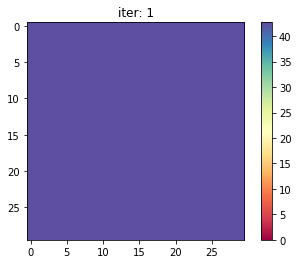

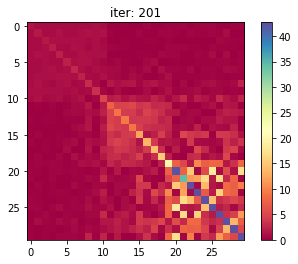

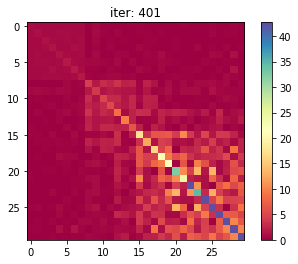

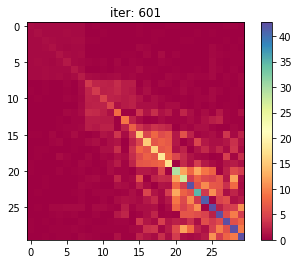

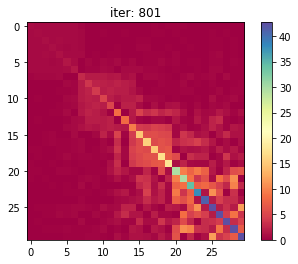

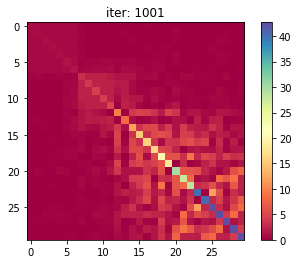

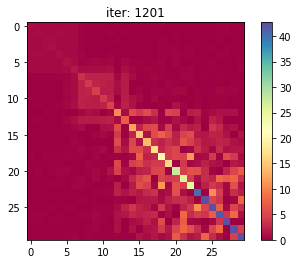

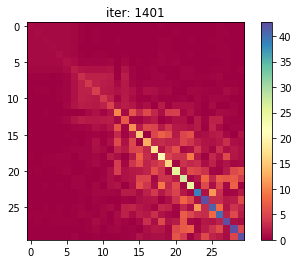

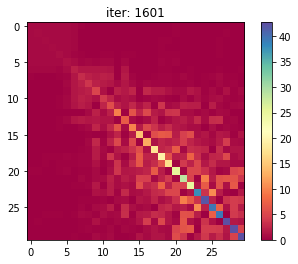

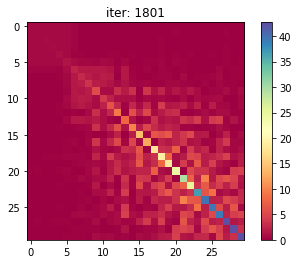

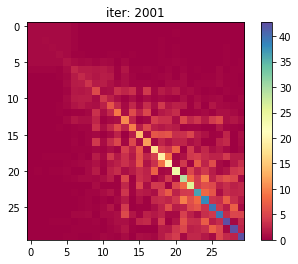

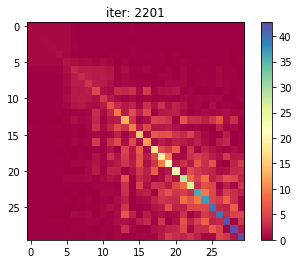

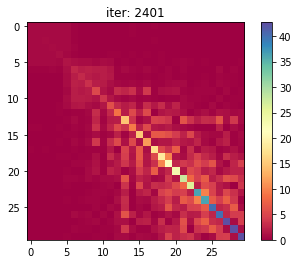

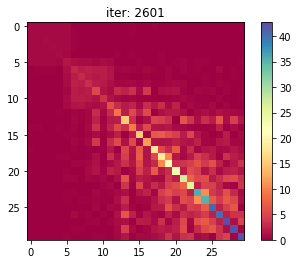

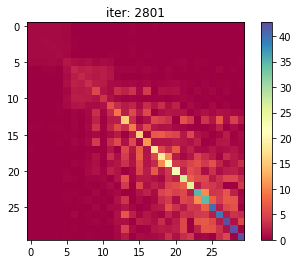

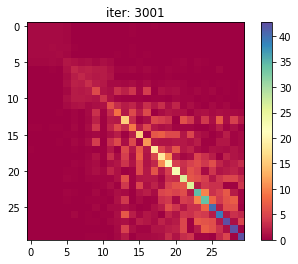

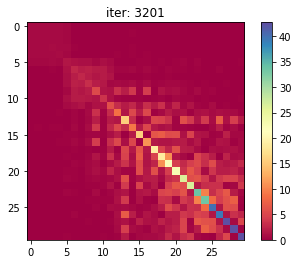

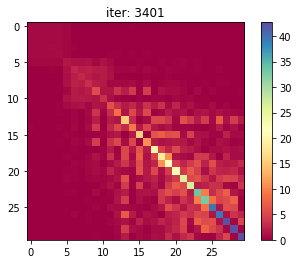

In [55]:
# hproj progress
vmax=eigs_diag[:N_proj].abs().max()
vmin=0
for it, hp in zip(its,hps):
    Hplt = hp.cpu().detach().numpy()
    plt.imshow(np.abs(Hplt), origin="upper", cmap='Spectral', interpolation=None, vmax=vmax, vmin=vmin)
    plt.title("iter: %i" % (it+1))
    plt.colorbar()
    plt.show()

### Make an animation

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


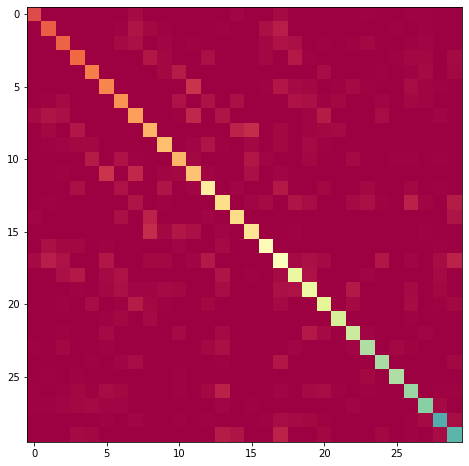

In [103]:
fig = plt.figure()
fig.set_size_inches(8,8, True)
ax = plt.axes()
vmax=eigs_diag[:N_proj].abs().max()
vmin=0
Hplt = hps[0].cpu().detach().numpy()
mat = plt.imshow(np.abs(Hplt), origin="upper", cmap='Spectral', interpolation=None, vmax=vmax, vmin=vmin)


def init():
    mat.set_data(hps[0].cpu().detach().numpy())
    return mat,
def animate(i):
    hp = hps[i].cpu().detach().numpy()
    mat.set_data(hp)
    return mat,

anim = FuncAnimation(fig, animate, init_func=init,
                               frames=len(hps), interval=90, blit=True)


anim.save('diagonalization.gif', writer='imagemagick')